In [39]:
import sqlite3
import os
import pandas as pd
import operator

# change to the directory where the files are stored
os.chdir("/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework/dataverse_files")

try:
    os.remove('airline2.db')
except OSError:
    pass



# ======= create database =======
conn = sqlite3.connect('airline2.db')

data1999= pd.read_csv("1999.csv")
print(data1999.shape)
data2000= pd.read_csv("2000.csv")
print(data2000.shape)
#data1999.info(verbose =False)
#data2000.info(verbose = False)

#df2 = pd.concat([df, df1], ignore_index=True, sort=False)
ontime_df = pd.concat([data1999,data2000], ignore_index=True, sort=False)
airports_df = pd.read_csv("airports.csv")
carriers_df = pd.read_csv("carriers.csv")
planes_df = pd.read_csv("plane-data.csv")
#print(ontime_df.head)


# ======= statistics summary =======
summaryAirports = airports_df.describe(include='all')
#print(summaryAirports)

summaryCarriers = carriers_df.describe(include='all')
#print(summaryCarriers)

summaryPlanes = planes_df.describe(include='all')
#print(summaryPlanes)

summaryOntime = ontime_df.describe(include='all')
#print(summaryOntime)

c = conn.cursor()
c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')
conn.commit()




for year in range(1999, 2000):
    ontime = pd.read_csv(str(year)+".csv")
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()


# ======= getting the deptime for flights that delay less than 5 mins  =======
timeOfDay= c.execute(''' SELECT DepTime AS DepTime FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()

column_name=["DepTime"]
timeOfDayPd=pd.DataFrame(timeOfDay, columns= column_name)

# ======= Answering Q1 best time of the week to fly   =======
timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].astype(str).str.zfill(4)
print(timeOfDayPd)
type(timeOfDayPd)

earlyMornCount=0  
midMornCount=0
lateMornCount=0
earlyAftCount=0
midAftCount=0
lateAftCount= 0
earlyEveCount=0
midEveCount=0
lateEveCount=0 
earlyOverCount=0
midOverCount=0
lateOverCount=0

for index, i in timeOfDayPd.iterrows():  
    #print(int(i['DepTime']))
    
    if 600<= int(i['DepTime']) <=800:
        
        earlyMornCount+=1
        #print(type(i['DepTime']))
            #print({'col1':i['DepTime']})
            
    elif 800<= int(i['DepTime']) <= 1000:   
        midMornCount+=1
        
    elif 1000<= int(i['DepTime']) <= 1200:   
        lateMornCount+=1
        
    elif 1200 <= int(i['DepTime']) <= 1400:
        earlyAftCount+=1
       #print(timeOfDayPdMorn)    
    
    elif 1400 <= int(i['DepTime']) <= 1600:
        midAftCount+=1
        
    elif  1600 <= int(i['DepTime']) <= 1800:
          lateAftCount+=1
            
    elif  1800 <= int(i['DepTime']) <= 2000:
         earlyEveCount+=1
        
    elif  2000 <= int(i['DepTime']) <= 2200:   
        midEveCount+=1
        
    elif  2200 <= int(i['DepTime']) <= 2359:     
        lateEveCount+=1
        
    elif  1 <= int(i['DepTime']) <= 200: 
        earlyOverCount+=1
        
    elif  200 <= int(i['DepTime']) <= 400: 
        midOverCount+=1
        
    elif  400 <= int(i['DepTime']) <= 600: 
        lateOverCount+=1
        
print( earlyMornCount) 
print( midMornCount)
print(lateMornCount)
print(earlyAftCount)
print(midAftCount)
print(lateAftCount)
print(earlyEveCount)
print(midEveCount)
print(lateEveCount)
print( earlyOverCount)
print(midOverCount)

print("Best time of the day to fly is early morning from 0600 to 0800")

#timeOfDayPdMorn2=pd.DataFrame(timeOfDayPdMorn, columns= column_name)
#print(len(timeOfDayPdMorn2))    
#print(timeOfDayPdMorn2)

    
        
       
   
    







(5527884, 29)
(5683047, 29)
        DepTime
0          1907
1          1534
2          1539
3          1533
4          0604
...         ...
3001942    1912
3001943    1910
3001944    1909
3001945    1907
3001946    1907

[3001947 rows x 1 columns]
515643
428757
379245
370613
329969
325405
289437
228441
73638
15248
862
Best time of the day to fly is early morning from 0600 to 0800


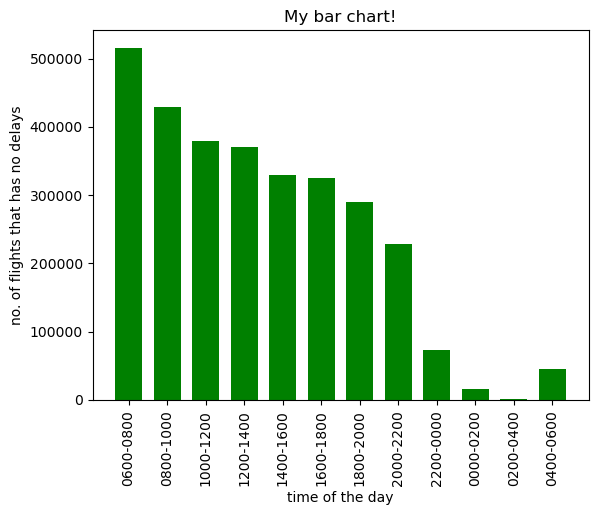

In [49]:
# ======= plotting graph for Q1a  =======

import pandas as pd
from matplotlib import pyplot as plt

  
# x-coordinates of left sides of bars  
left = [0, 1, 2, 3, 4, 5, 6, 7,8,9,10, 11] 
  
# heights of bars 
height = [earlyMornCount,midMornCount, lateMornCount , earlyAftCount, midAftCount, lateAftCount, earlyEveCount, 
          midEveCount,lateEveCount, earlyOverCount, midOverCount, lateOverCount ] 
  
    

# labels for bars 

tick_label = ['0600-0800', '0800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', 
              '2000-2200', '2200-0000',
               '0000-0200', '0200-0400', '0400-0600'] 

y_pos = range(len(tick_label))  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.7, color = ['green']) 

plt.xticks(y_pos , tick_label , rotation=90)
# naming the x-axis 
plt.xlabel('time of the day') 
# naming the y-axis 
plt.ylabel('no. of flights that has no delays') 
# plot title 
plt.title('My bar chart!') 
  
# function to show the plot 
plt.show() 





#heights = [10, 20, 15]
#bars = ['A_long', 'B_long', 'C_long']
#y_pos = range(len(bars))
#plt.bar(y_pos, heights)
# Rotation of the bars names
#plt.xticks(y_pos, bars, rotation=90)

In [9]:
# ======= Answering Q1b best day of the week to fly to minimize delays   =======


# ======= getting the day of week for flights that delay less than 5 mins  =======
dayOfWeek= c.execute(''' SELECT DayOfWeek  AS DayOfWeek FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()

column_name=["DayOfWeek"]
dayOfWeekPd=pd.DataFrame(dayOfWeek, columns= column_name)
print(dayOfWeekPd)


monCount=0  
tuesCount=0
wedCount=0
thursCount=0
friCount=0
satCount=0
sunCount=0
for index, i in dayOfWeekPd.iterrows():  

    if int(i['DayOfWeek']) ==1:
            monCount+=1
    
    elif int(i['DayOfWeek']) ==2:
         tuesCount+=1
    
    elif int(i['DayOfWeek']) ==3:
         wedCount+=1
            
    elif int(i['DayOfWeek']) ==4:
         thursCount+=1
            
    elif int(i['DayOfWeek']) ==5:
         friCount+=1
            
    elif int(i['DayOfWeek']) ==6:
         satCount+=1
            
    else:
         sunCount+=1
    
print(monCount)
print(tuesCount)
print(wedCount)
print(thursCount)
print(friCount)
print(satCount)
print(sunCount)

print("Best day of the week to fly is on a Tuesday")

         DayOfWeek
0                5
1                4
2                6
3                6
4                6
...            ...
3001942          3
3001943          4
3001944          5
3001945          6
3001946          7

[3001947 rows x 1 columns]
448446
468732
448818
412717
398293
414394
410547


In [ ]:
print('fuck')